In [4]:
# 평가 이미지 리스트
BASE_DIR = '/data/kts123/aihub/reid'
test_imgs = '/data/kts123/aihub/reid/img_list_test.txt'

# 훈련된 모델경로
weight_path = '/home/kts123/gc2021/3차/track3/arcface/checkpoints_res50_base/scheduler_resnet50_99.pth'

In [8]:
# 평가용 데이터셋
from data import dataset
ds = dataset.DataSet(BASE_DIR, test_imgs, phase='test')

In [9]:
# 평가용 데이터로더 생성
from torch.utils.data import DataLoader
dl = DataLoader(ds, num_workers=4, batch_size=32)

torch.Size([3, 224, 224])


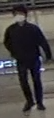

In [13]:
# 샘플 이미지 출력
from PIL import Image
im, kls, path = ds[2]
print(im.shape)
Image.open(path)

In [ ]:
# 모델 로드
def load_model(model, model_path):
    model_dict = model.state_dict()
    pretrained_dict = torch.load(model_path)
    pretrained_dict = {k:v for k, v in pretrained_dict.items() if k in model_dict}
    no_model_keys = [k for k, _ in pretrained_dict.items() if k in model_dict]
    print('no_model_keys:', no_model_keys)

    model_dict.update(pretrained_dict)
    model.load_state_dict(model_dict)